# Word embeddings validation

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
from pathlib import Path
from IPython.display import display, Markdown

# Add the project root to the Python path to import the modules
project_root = Path().absolute().parent
sys.path.append(str(project_root))

from utils.validation_helpers import load_models_from_directory, kmeans_cluster_embeddings, validate_models_similarity_task, validate_models_analogy_task
from utils.visualisations_helpers import display_similarity_results_table, display_analogy_category_table

In [3]:
# Load all trained models
print("Loading models...")
models = load_models_from_directory('../models')

print(f"\nLoaded {len(models)} models:")
for model_name, model in models.items():
    vocab_size = len(model.wv.index_to_key)
    vector_size = model.vector_size
    # Calculate the total number of tokens (sum of word counts)
    total_tokens = sum(model.wv.get_vecattr(word, "count") for word in model.wv.index_to_key)
    print(f"  {model_name}:\n      Vocabulary size: {vocab_size} \n      {total_tokens:,} tokens \n      Vector size: {vector_size}")

Loading models...
Loaded model: frWac_200_cbow
Loaded model: frRap_200_skip
Loaded model: frWiki_1000_cbow
Loaded model: frWac_200_skip
Loaded model: frWiki_1000_skip
Loaded model: frRap_200_cbow
Loaded model: frRap_100_skip
Loaded model: frRap_100_cbow

Loaded 8 models:
  frWac_200_cbow:
      Vocabulary size: 155562 
      12,099,845,703 tokens 
      Vector size: 200
  frRap_200_skip:
      Vocabulary size: 26149 
      3,835,340 tokens 
      Vector size: 200
  frWiki_1000_cbow:
      Vocabulary size: 66274 
      2,196,154,675 tokens 
      Vector size: 1000
  frWac_200_skip:
      Vocabulary size: 155562 
      12,099,845,703 tokens 
      Vector size: 200
  frWiki_1000_skip:
      Vocabulary size: 66274 
      2,196,154,675 tokens 
      Vector size: 1000
  frRap_200_cbow:
      Vocabulary size: 26149 
      3,835,340 tokens 
      Vector size: 200
  frRap_100_skip:
      Vocabulary size: 26149 
      3,835,340 tokens 
      Vector size: 100
  frRap_100_cbow:
      Vocabulary si

## Intrinsic Evaluation 1 - Clustering and visualisation

To get a first idea of their validity, I use k-means clustering on the word embeddings, then visualise the results after reducing dimensionality with t-SNE.

In [10]:
best_rap_model = models["frRap_100_skip"]

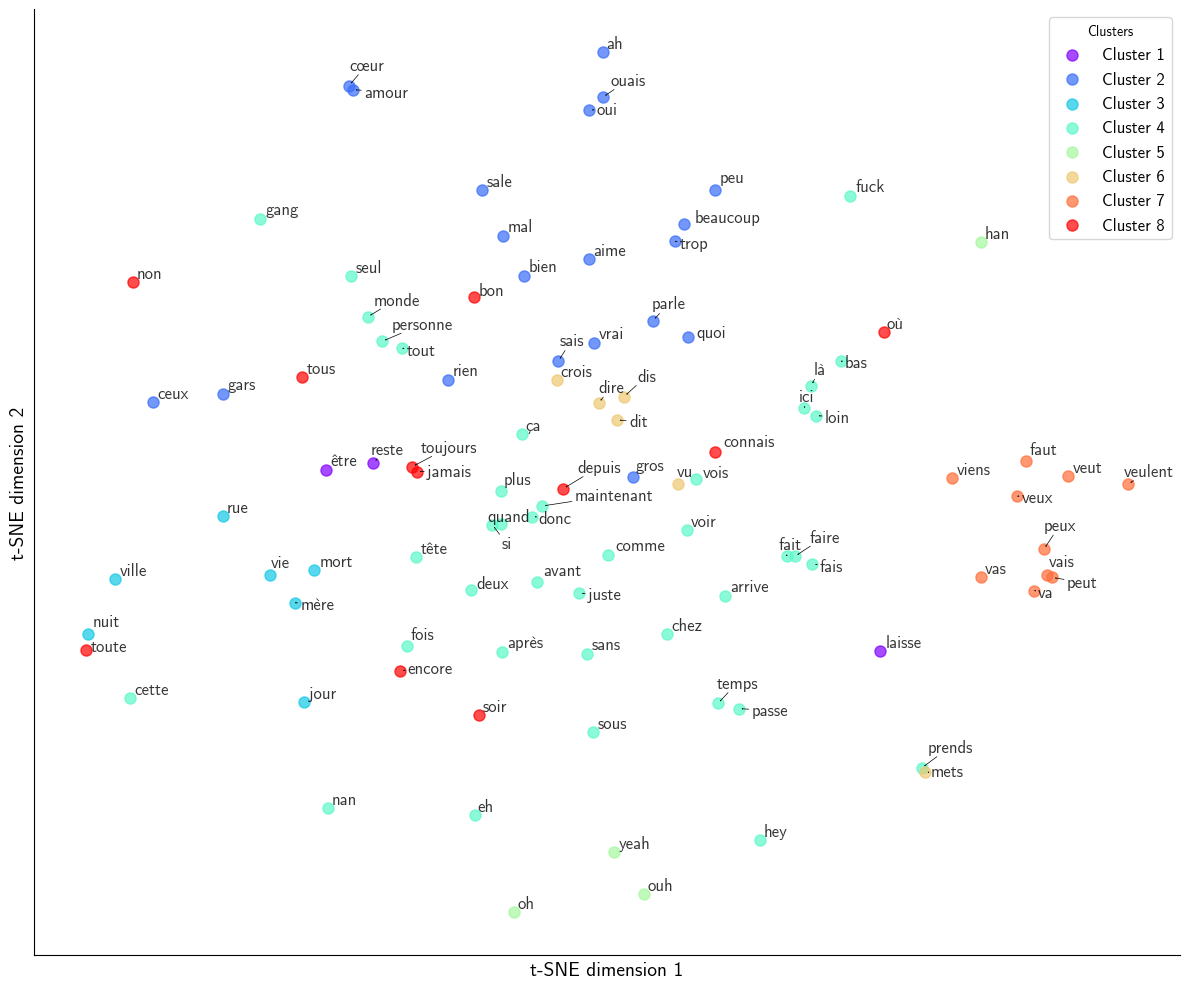

In [ ]:
# Run k-means clustering
n_clusters = 8

cluster_info = kmeans_cluster_embeddings(
    best_rap_model, 
    n_words=100,
    n_clusters=n_clusters,
    random_state=42,
    save_path=f'../figs/k_means/kmeans_word_clusters_{n_clusters}_new.png'
)

## Intrinsic Evaluation 2- Semantic similarity

As a more formal way to validate the word embeddings created, I assess semantic similarity. The idea is to compare levels of similarity (using cosine distance) represented by my word embeddings to pairs of words generally considered as similar. Due to the lack of gold-standard dataset for this task in French, I translated Finkelstein et al. (2001)'s WordSim353 [1] [2]. This dataset contains 353 word pairs, each associated with an average of 13 to 16 human judgements on their similarity. Importantly, both similarity and relatedness, which are two distinct concepts, are annotated without distinction. However, studies have found that human scores for both are very highly correlated with each other [3]. The trivial `tiger--tiger` pair was omitted, along with pairs where the translated words were the same. Finally, I also removed pairs whose association in English had no equivalent in French (e.g. 'soap' and 'opera').

----
[1]: Finkelstein, L., Gabrilovich, E., Matias, Y., Rivlin, E., Solan, Z., Wolfman, G., & Ruppin, E. (2001). Placing search in context: The concept revisited. Proceedings of the 10th International Conference on World Wide Web, 406–414. https://doi.org/10.1145/371920.372094

[2]: Available at https://www.kaggle.com/datasets/julianschelb/wordsim353-crowd/data

[3]: (Miller and Charles, 1991; Resnik, 1995) as cited in Agirre, E., Alfonseca, E., Hall, K., Kravalova, J., Paşca, M., & Soroa, A. (2009). A study on similarity and relatedness using distributional and WordNet-based approaches. Proceedings of Human Language Technologies: The 2009 Annual Conference of the North American Chapter of the Association for Computational Linguistics, 19–27.

In [4]:
similarity_test_results_df = validate_models_similarity_task(models, show_plot=False)


Evaluating frWac_200_cbow on word similarity...
Number of word pairs not in vocabulary: 26 / 346 (7.51%)
Evaluation results:
Pearson correlation: 0.5588 (p-value: 0.0000)
Spearman correlation: 0.5668 (p-value: 0.0000)

Evaluating frRap_200_skip on word similarity...
Number of word pairs not in vocabulary: 90 / 346 (26.01%)
Evaluation results:
Pearson correlation: 0.1981 (p-value: 0.0014)
Spearman correlation: 0.1928 (p-value: 0.0019)

Evaluating frWiki_1000_cbow on word similarity...
Number of word pairs not in vocabulary: 28 / 346 (8.09%)
Evaluation results:
Pearson correlation: 0.1733 (p-value: 0.0019)
Spearman correlation: 0.1425 (p-value: 0.0109)

Evaluating frWac_200_skip on word similarity...
Number of word pairs not in vocabulary: 26 / 346 (7.51%)
Evaluation results:
Pearson correlation: 0.5298 (p-value: 0.0000)
Spearman correlation: 0.5319 (p-value: 0.0000)

Evaluating frWiki_1000_skip on word similarity...
Number of word pairs not in vocabulary: 28 / 346 (8.09%)
Evaluation re

In [ ]:
similarity_results_md = display_similarity_results_table(similarity_test_results_df)

display(Markdown(similarity_results_md))

| Model            | Pearson's r (p-value)   | Spearman's r (p-value)   | Pairs (coverage)   |
|:-----------------|:------------------------|:-------------------------|:-------------------|
| frWac_200_cbow   | **0.56 (1.13e-27)**     | **0.57 (1.35e-28)**      | 320/346 (92.5%)    |
| frWac_200_skip   | 0.53 (1.48e-24)         | 0.53 (8.97e-25)          | 320/346 (92.5%)    |
| frWiki_1000_skip | 0.52 (2.63e-23)         | 0.54 (2.11e-25)          | 318/346 (91.9%)    |
| frRap_100_cbow   | 0.23 (1.73e-04)         | 0.23 (1.62e-04)          | 256/346 (74.0%)    |
| frRap_100_skip   | 0.23 (1.91e-04)         | 0.23 (1.71e-04)          | 256/346 (74.0%)    |
| frRap_200_cbow   | 0.22 (3.96e-04)         | 0.21 (5.39e-04)          | 256/346 (74.0%)    |
| frRap_200_skip   | 0.20 (1.44e-03)         | 0.19 (1.95e-03)          | 256/346 (74.0%)    |
| frWiki_1000_cbow | 0.17 (1.92e-03)         | 0.14 (1.09e-02)          | 318/346 (91.9%)    |

In [ ]:
# Show the plots of the best models for FrRap and FrWac
from PIL import Image

image1_path = "../figs/similarity_corr/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100_similarity_correlation.png"
image2_path = "../figs/similarity_corr/frRap_non_lemma_cbow_100_cut5_win5_similarity_correlation.png"

# Open the images
img1 = Image.open(image1_path)
img2 = Image.open(image2_path)

# Get dimensions
width = max(img1.width, img2.width)
height = img1.height + img2.height

# Create a new blank image
stitched_img = Image.new("RGB", (width, height))

# Paste images
stitched_img.paste(img1, (0, 0))
stitched_img.paste(img2, (0, img1.height))

# Save or show the stitched image
stitched_img.save("../figs/similarity_corr/stitched_similarity_correlation.png")

## Intrinsic validation 3 - Analogies

For the final part of the validation process, I partly follow Abdine et al. (2022)'s methodology of evaluating word embeddings [1]. Their first step is the **analogy task** [2]. In this task, we predict a word D by analyzing the semantic relationships between three input words A, B, and C. The prediction operates on the assumption that high-quality word embeddings preserve linear relationships between word pairs.

The process works as follows:

1. Given words A, B, and C, we access their vector representations (xA, xB, xC).
2. We compute a new vector using the formula: xB - xA + xC
3. We search the embedding dictionary for the word vector most similar to this result, which becomes our predicted word D.

For example, if we input "king," "man," and "woman," a good embedding system should predict "queen" because the relationship between "king" and "man" parallels the relationship between "queen" and "woman." Performance is measured by calculating the average accuracy across all test cases in the evaluation set. This approach effectively assesses how well word embeddings capture semantic relationships between concepts.

To evaluate my word embeddings, I utilised the French analogy dataset developed by Grave et al. (2018). This comprehensive dataset contains 31,688 analogy questions designed to test semantic and syntactic relationships [3]. I benchmarked my embeddings against three established French word vector models:

- French FastText (cc.fr.300) - also created by Grave et al. (2018)
- French Wacky word vectors
- Abdine et al. (2022)'s CBoW and Skip-Gram models trained on Large-Scale French Web Content

This comparative evaluation allows me to assess the relative performance of my embeddings against well-established baselines in capturing linguistic relationships within the French language context.

---------
[1]: Abdine, H., Xypolopoulos, C., Eddine, M. K., & Vazirgiannis, M. (2022). Evaluation Of Word Embeddings From Large-Scale French Web Content (No. arXiv:2105.01990). arXiv. https://doi.org/10.48550/arXiv.2105.01990

[2]: Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space (No. arXiv:1301.3781). arXiv. https://doi.org/10.48550/arXiv.1301.3781

[3]: Grave, E., Bojanowski, P., Gupta, P., Joulin, A., & Mikolov, T. (2018). Learning Word Vectors for 157 Languages. In N. Calzolari, K. Choukri, C. Cieri, T. Declerck, S. Goggi, K. Hasida, H. Isahara, B. Maegaard, J. Mariani, H. Mazo, A. Moreno, J. Odijk, S. Piperidis, & T. Tokunaga (Eds.), Proceedings of the Eleventh International Conference on Language Resources and Evaluation (LREC 2018). European Language Resources Association (ELRA). https://aclanthology.org/L18-1550/

In [9]:
# Word analogy task from Grave et al., 2018
# Source: https://fasttext.cc/docs/en/crawl-vectors.html

# Evaluate the full model and save correct analogies
analogies_test_results_df = validate_models_analogy_task(models, save_correct=False)

Parsed 14 categories with a total of 31562 questions

Evaluating model: frWac_200_cbow
  Accuracy: 0.3730, Skipped: 23980

Evaluating model: frRap_200_skip
  Accuracy: 0.0265, Skipped: 27672

Evaluating model: frWiki_1000_cbow
  Accuracy: 0.0024, Skipped: 26224

Evaluating model: frWac_200_skip
  Accuracy: 0.3610, Skipped: 23980

Evaluating model: frWiki_1000_skip
  Accuracy: 0.3782, Skipped: 26224

Evaluating model: frRap_200_cbow
  Accuracy: 0.0810, Skipped: 27672

Evaluating model: frRap_100_skip
  Accuracy: 0.0368, Skipped: 27672

Evaluating model: frRap_100_cbow
  Accuracy: 0.0820, Skipped: 27672


In [10]:
# Remove columns with NA values
analogies_test_results_df_modified = analogies_test_results_df.copy()
analogies_test_results_df_modified = analogies_test_results_df_modified.dropna(axis=1, how='all')

analogies_results_md = display_analogy_category_table(analogies_test_results_df_modified, top_n_models=8)

display(Markdown(analogies_results_md))

| Model            | Overall   | Antonyms Adjectives   | Family    | Gram1 Adjective To Adverb   | Gram2 Opposite   | Gram3 Present Participle   | Gram4 Past Participle   | Gram5 Plural   | Gram7 Past Tense   | Gram8 Plural Verbs   |
|:-----------------|:----------|:----------------------|:----------|:----------------------------|:-----------------|:---------------------------|:------------------------|:---------------|:-------------------|:---------------------|
| frWiki_1000_skip | **37.8%** | **27.8%**             | 51.4%     | N/A                         | 20.8%            | **47.4%**                  | 30.3%                   | 54.8%          | 13.3%              | 15.4%                |
| frWac_200_cbow   | 37.3%     | 16.8%                 | 68.8%     | 18.1%                       | 22.1%            | 35.2%                      | **32.7%**               | **67.9%**      | **34.9%**          | **40.2%**            |
| frWac_200_skip   | 36.1%     | 9.3%                  | **72.9%** | **21.5%**                   | **22.4%**        | 45.4%                      | 25.4%                   | 62.8%          | 33.9%              | 32.5%                |
| frRap_100_cbow   | 8.2%      | 2.9%                  | 8.2%      | 0.0%                        | 0.0%             | 7.6%                       | 13.6%                   | 3.6%           | 16.1%              | 7.1%                 |
| frRap_200_cbow   | 8.1%      | 2.9%                  | 8.7%      | 0.0%                        | 1.6%             | 7.1%                       | 13.0%                   | 4.5%           | 15.2%              | 1.8%                 |
| frRap_100_skip   | 3.7%      | 2.2%                  | 5.3%      | 0.0%                        | 0.0%             | 0.4%                       | 7.3%                    | 0.8%           | 6.0%               | 3.6%                 |
| frRap_200_skip   | 2.6%      | 0.4%                  | 5.8%      | 0.0%                        | 0.5%             | 0.4%                       | 4.8%                    | 0.5%           | 5.8%               | 0.0%                 |
| frWiki_1000_cbow | 0.2%      | 0.0%                  | 4.3%      | N/A                         | 0.0%             | 0.0%                       | 0.3%                    | 0.1%           | 0.0%               | 0.0%                 |

**!! Limitation of the study: No extrinsic evaluation !!**

Extrinsic evaluation, which consists of testing the word embeddings on external tasks such as NER or parts-of-speech tagging, would allow to evaluate the actual usefulness of the embeddings.